# Exploring Mumbai

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction <a name="introduction"></a>

The aim of the project is to identify various venues in Mumbai, India based on their rating and average prices. In this notebook, we will identify various venues in the city of Mumbai, using Foursquare API and Zomato API, to help visitors select the restaurants that suit them the best.

Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.

Here, we'll identify places that are fit for various individuals based on the information collected from the two APIs and Data Science.

## Data <a name="data"></a>

### Data Collection

To start our project, we will take a look at Mumbai on the Map using the folium library.

We will also fetch the data from two different APIs.
<ul>
<li><b>Foursquare API:</b> We will use the Foursquare API to fetch venues in Mumbai starting from the middle upto 44 Kilometers in each direction.</li>
    <li><b>Zomato API:</b> The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.</li>
</ul>

In [1]:
MU_LATITUDE = 19.0760
MU_LONGITUDE = 72.8777
print('The geograpical coordinates of Mumbai are {}, {}.'.format(MU_LATITUDE, MU_LONGITUDE))

The geograpical coordinates of Mumbai are 19.076, 72.8777.


Using <b>folium</b> library to create a map of Gwalior:

In [2]:
import folium

mu_map = folium.Map(location = [MU_LATITUDE, MU_LONGITUDE], zoom_start = 15)
folium.Marker([MU_LATITUDE, MU_LONGITUDE]).add_to(mu_map)
mu_map.save("maps/mu Map.html")
mu_map

### Foursquare API
We begin by fetching a total of all venues in Mumbai upto a range of 4 Kilometers using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [3]:
FOURSQUARE_CLIENT_ID = '<your Client id>'
FOURSQUARE_CLIENT_SECRET = '<your client secret>'
RADIUS = 4000 # 4 Km
NO_OF_VENUES = 100
VERSION = '20200515' # Current date

To get the correct category for the venues,we gefine get_category function:

In [4]:
def get_category(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.
<ul>
    
<li>Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account.</li>
<li>We will set the radius as 4 Kilometers.</li>
<li>The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.</li>

</ul>

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        MU_LATITUDE, 
                                                                        MU_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 4.0 Km
Total 81 venues fetched within a total radius of 4.0 Km

Total 181 venues fetched


### Zomato API
The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.
<UL>
<LI>The query will be the name of the venue.
<LI>The start defines from what offset we want to start, so we'll keep it at 0.
<LI>The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
<LI>We will supply the latitude and longitude values.
<LI>We will set the sorting criteria as real_distance so each time we get the venue we're searching based on location coordinates.
</UL>

In [6]:
headers = {'user-key': '<your zomato api user key>'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

The data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [7]:
mu_map = folium.Map(location = [MU_LATITUDE, MU_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(mu_map)  

mu_map.save("maps/Foursquare Venues.html")
mu_map

From the map, we can infer that there are clusters of venues around Ghatkopar, Chembur, Santa Cruz West, Bandra Kurla Comlex and Marol Naka. We can also plot the category count and see the major type of venues that exist.

We will also plot the Zomato data on the map.

In [11]:
mu_map = folium.Map(location = [MU_LATITUDE, MU_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(mu_map)  

mu_map.save("maps/Venues by Zomato.html")
mu_map

We can see that there are many venues identified by both Foursquare and Zomato. There is a lot of overlapping between the two near Ghatkopar, Chembur, Bandra Kurla Comlex and Marol Naka. 

However, there are others where the data does not match just like the red dots in the bottom right on the second map.

To combine the two datasets, we 'll have to check that the latitude and longitude values of each corresponding venue match. Thus, We'll round both the latitude and longitude values upto 4 decimal places. Then, We'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [12]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [13]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [14]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Sofitel Mumbai BKC,Hotel,19.0674,72.8690,Tuskers - Sofitel,19.0673,72.8692,3300.0,4.0,4.0,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai",-0.0001,0.0002
1,Trident,Hotel,19.0668,72.8675,O22 - Trident,19.0672,72.8675,4000.0,4.0,4.0,"Trident Hotel, C 56, G Block, Bandra Kurla Com...",0.0004,0.0000
2,Masala Library,Indian Restaurant,19.0689,72.8697,Masala Library,19.0690,72.8696,5000.0,4.0,4.4,"Ground Floor, First International Financial Ce...",0.0001,-0.0001
3,Natural's Ice Cream,Ice Cream Shop,19.0776,72.8630,Natural Ice Cream,19.0776,72.8628,300.0,1.0,4.1,"3, Gokul Harmony, Kalina Market, Sunder Nagar,...",0.0000,-0.0002
4,Smoke House Deli (BKC),Deli / Bodega,19.0688,72.8697,Smoke House Deli,19.0688,72.8695,2500.0,4.0,4.3,"3A, Ground Floor, 1st International Financial ...",0.0000,-0.0002
5,Yauatcha,Dim Sum Restaurant,19.0614,72.8627,Yauatcha,19.0611,72.8626,2800.0,4.0,4.5,"Raheja Towers, Bandra Kurla Complex, Mumbai",-0.0003,-0.0001
6,Delhi Zaika,Indian Restaurant,19.0771,72.8783,Delhi Zaika,19.0770,72.8784,700.0,2.0,3.8,"5/6, Near Kamran Kalpana Theater, LBS Marg, Ku...",-0.0001,0.0001
7,Theobrama,Dessert Shop,19.0635,72.8617,Theobroma,19.0637,72.8621,900.0,2.0,4.2,"The Capital, Ground Floor, Bandra Kurla Comple...",0.0002,0.0004
8,Starbucks,Coffee Shop,19.0866,72.8898,Starbucks Coffee,19.0865,72.8898,700.0,2.0,4.1,"First Floor, Phoenix Market City, LBS Marg, Ku...",-0.0001,0.0000
9,SodaBottleOpenerWala,Irani Cafe,19.0636,72.8624,SodaBottleOpenerWala,19.0638,72.8620,1500.0,3.0,4.1,"Ground Floor, The Capital Building, G Block, B...",0.0002,-0.0004


In [15]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [16]:
selected_venues.head(5)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Hotel,Tuskers - Sofitel,19.0673,72.8692,4.0,4.0,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai",1650.0
1,Hotel,O22 - Trident,19.0672,72.8675,4.0,4.0,"Trident Hotel, C 56, G Block, Bandra Kurla Com...",2000.0
2,Indian Restaurant,Masala Library,19.0690,72.8696,4.0,4.4,"Ground Floor, First International Financial Ce...",2500.0
3,Ice Cream Shop,Natural Ice Cream,19.0776,72.8628,1.0,4.1,"3, Gokul Harmony, Kalina Market, Sunder Nagar,...",150.0
4,Deli / Bodega,Smoke House Deli,19.0688,72.8695,4.0,4.3,"3A, Ground Floor, 1st International Financial ...",1250.0


In [17]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 75


## Methodology <a name="methodology"></a>

This project aims at identifying the venues in Mumbai based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, we retrieved the data from two APIs (Foursquare and Zomato). We extract venue information from the center of Mumbai, upto a distance of 4 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we then explored the data retrieved from the two APIs on the map and identified the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll analyse the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore areas that are high rated and those that are low rated while also plotting the map of high and low priced venues. Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

## Analysis <a name="analysis"></a>

The complete dataset is now in its final form.

We will inspect these venues based on their rating. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also analyse the venues based on their price per person as well as the price range.

<BarContainer object of 29 artists>

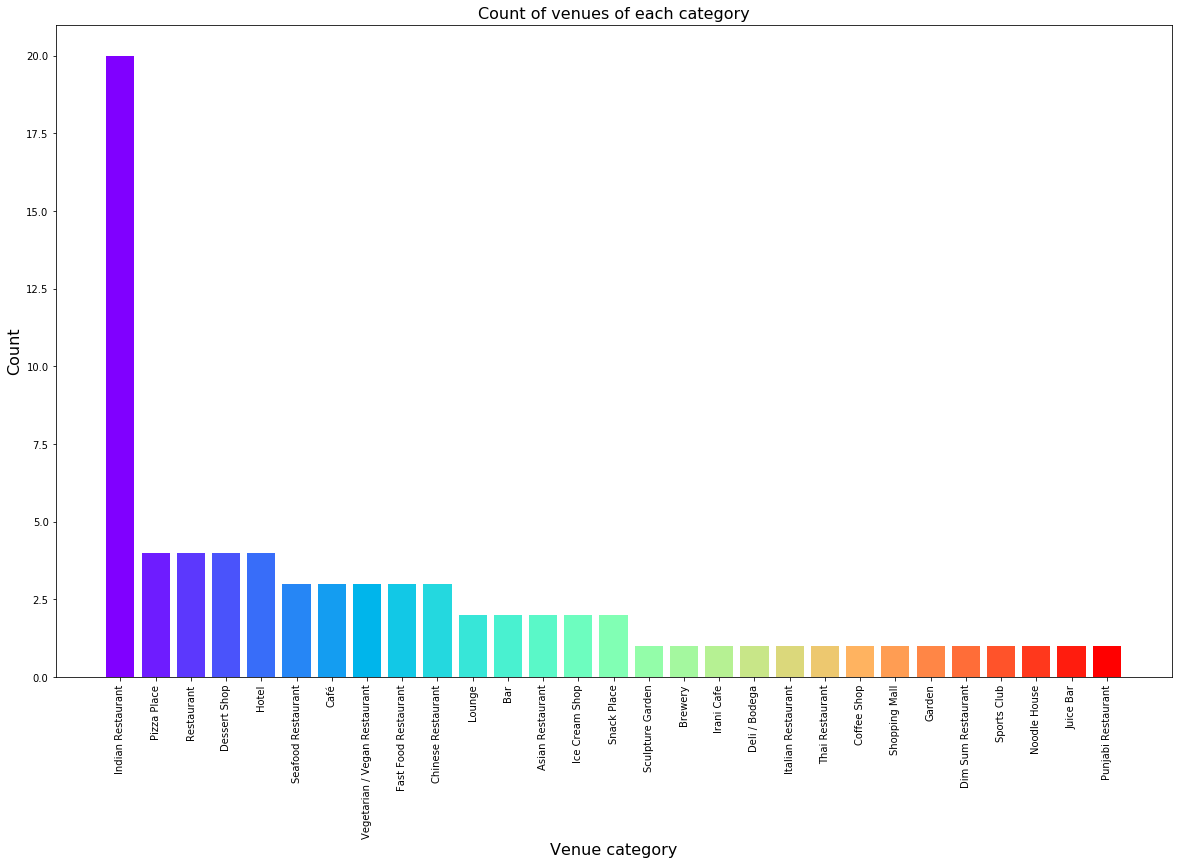

In [18]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can see the majority venues are Indian Restaurant. So a user has variety of options to choose from.

### Rating
Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

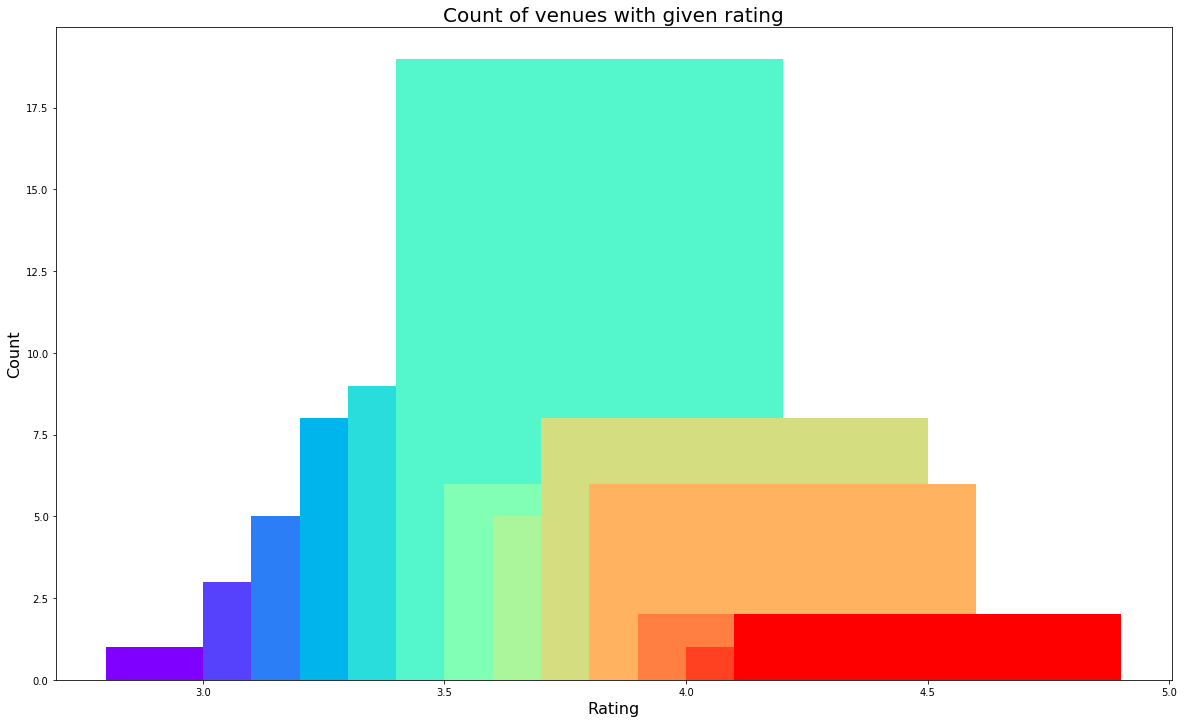

In [19]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 20)

From the plot above, it is clear that majority venues have their rating close to 3.75  .

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:
<ul>
<li>1 to 2
<li>2 to 3
<li>3 to 4
<li>4 to 5

In [20]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

In [21]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

mu_map = folium.Map(location = [MU_LATITUDE, MU_LONGITUDE], zoom_start = 15)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(mu_map)  

mu_map.save("maps/Venues-Ratings.html")
mu_map

### Price
We will now take a look the venues based on the price values. We have two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Zomato.

We will first explore the average_price using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

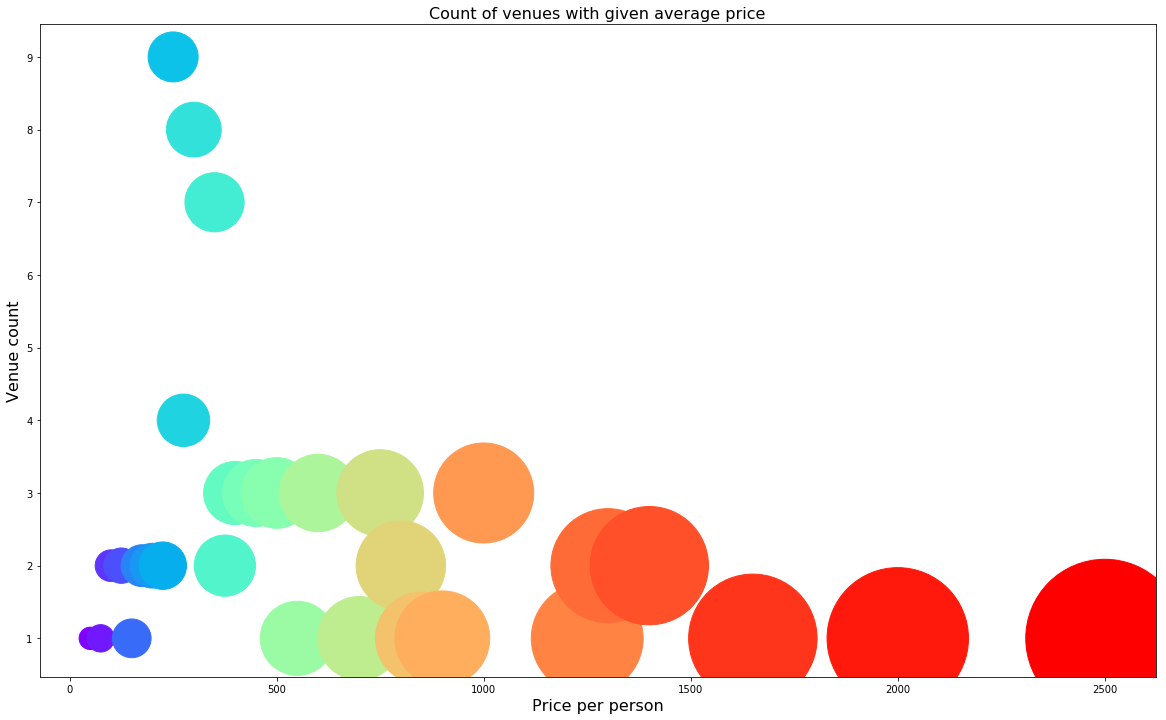

In [22]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot above we can see that a large number of venues have an average price between Rs 500 and Rs 1000.

Now,plotting the venues on the map using above data.

In [23]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

mu_map = folium.Map(location = [MU_LATITUDE, MU_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(mu_map)  

mu_map.save("maps/Venues-Prices.html")
mu_map

### Clustering
We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [24]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Hotel,Tuskers - Sofitel,19.0673,72.8692,4.0,4.0,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai",1650.0,Good
1,1,Hotel,O22 - Trident,19.0672,72.8675,4.0,4.0,"Trident Hotel, C 56, G Block, Bandra Kurla Com...",2000.0,Good
2,1,Indian Restaurant,Masala Library,19.0690,72.8696,4.0,4.4,"Ground Floor, First International Financial Ce...",2500.0,Very good
3,0,Ice Cream Shop,Natural Ice Cream,19.0776,72.8628,1.0,4.1,"3, Gokul Harmony, Kalina Market, Sunder Nagar,...",150.0,Very good
4,1,Deli / Bodega,Smoke House Deli,19.0688,72.8695,4.0,4.3,"3A, Ground Floor, 1st International Financial ...",1250.0,Very good


In [25]:
mu_map = folium.Map(location = [MU_LATITUDE, MU_LONGITUDE], zoom_start = 15)
color_map = { 0: 'red', 1: 'green'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(mu_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(mu_map)

mu_map.save("maps/Venues-Clusters.html")
mu_map

We can check the venues of the two clusters.

In [26]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Ice Cream Shop,Natural Ice Cream,19.0776,72.8628,1.0,4.1,"3, Gokul Harmony, Kalina Market, Sunder Nagar,...",150.0,Very good
1,0,Indian Restaurant,Delhi Zaika,19.0770,72.8784,2.0,3.8,"5/6, Near Kamran Kalpana Theater, LBS Marg, Ku...",350.0,Good
2,0,Dessert Shop,Theobroma,19.0637,72.8621,2.0,4.2,"The Capital, Ground Floor, Bandra Kurla Comple...",450.0,Very good
3,0,Coffee Shop,Starbucks Coffee,19.0865,72.8898,2.0,4.1,"First Floor, Phoenix Market City, LBS Marg, Ku...",350.0,Very good
4,0,Irani Cafe,SodaBottleOpenerWala,19.0638,72.8620,3.0,4.1,"Ground Floor, The Capital Building, G Block, B...",750.0,Very good
5,0,Indian Restaurant,Naaz Hotel,19.0846,72.8893,2.0,4.1,"Kantharia Mahal, LBS Road, Opposite Phoenix Ma...",350.0,Very good
6,0,Restaurant,Ivy Restaurant and Banquets,19.0696,72.9004,3.0,4.1,"Above Shopper's Stop, Amar Mahal, Chembur, Mumbai",800.0,Very good
7,0,Chinese Restaurant,Hotel Darshan,19.0828,72.8851,1.0,3.5,"Opposite Kohinoor City Gate, Kurla West, Near ...",125.0,Good
8,0,Indian Restaurant,MOJO Pizza - 2X Toppings,19.0667,72.8667,2.0,4.2,"1, Near Vibgyor Tower, Bandra Kurla Complex, M...",300.0,Very good
9,0,Hotel,Love & Latte,19.1022,72.8782,2.0,3.9,"The ORB, Retail Arcade, Unit G2 & G3, Ground F...",450.0,Good


In [27]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 2.02 and rating spread around 3.79


In [28]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Hotel,Tuskers - Sofitel,19.0673,72.8692,4.0,4.0,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai",1650.0,Good
1,1,Hotel,O22 - Trident,19.0672,72.8675,4.0,4.0,"Trident Hotel, C 56, G Block, Bandra Kurla Com...",2000.0,Good
2,1,Indian Restaurant,Masala Library,19.0690,72.8696,4.0,4.4,"Ground Floor, First International Financial Ce...",2500.0,Very good
3,1,Deli / Bodega,Smoke House Deli,19.0688,72.8695,4.0,4.3,"3A, Ground Floor, 1st International Financial ...",1250.0,Very good
4,1,Dim Sum Restaurant,Yauatcha,19.0611,72.8626,4.0,4.5,"Raheja Towers, Bandra Kurla Complex, Mumbai",1400.0,Very good
5,1,Café,Shizusan,19.0864,72.8892,3.0,4.0,"F-97, Phoenix Marketcity, Near Kurla Fire Stat...",900.0,Good
6,1,Thai Restaurant,Yauatcha,19.0611,72.8626,4.0,4.5,"Raheja Towers, Bandra Kurla Complex, Mumbai",1400.0,Very good
7,1,Brewery,British Brewing Company,19.1077,72.8834,4.0,4.1,"Ground Floor, Times Square Tech Park, Andheri ...",1000.0,Very good
8,1,Italian Restaurant,British Brewing Company,19.1077,72.8834,4.0,4.1,"Ground Floor, Times Square Tech Park, Andheri ...",1000.0,Very good
9,1,Lounge,Wild Orchids,19.0616,72.9016,4.0,3.8,"Hotel Royal Orchid, NG Acharya Marg, Chembur, ...",1000.0,Good


In [29]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 3.92 and rating spread around 4.17


## Results and Discussion <a name="results"></a>

Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of <b>Mumbai</b>, India.

After collecting data from the <b>Foursquare</b> and <b>Zomato</b> APIs, we got a list of 181 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 75.

We identified that from the total set of venues, majority of them were <b>Indian Restaurants</b>. A visitor who loves Indian Restaurants would surely like to visit Mumbai.

While the complete range of ratings range from 1 to 5, the majority venues have ratings close to <b>3.75</b>. This means that most restaurants provide good quality food which is liked by the people of the city, thus indicating the high rating.

When we take a look at the price values of each venue, we explore that many venues have prices which are in the range of <b>Rs 500 to Rs 1000</b> for one person. However, the variation in prices is very large, given the complete range starts from <b>Rs 100</b> and goes uptil <b>Rs 2500</b>. On plotting the venues based on their price range on the map, we discovered that venues located near <b>Ghatkopar and Chembur</b> are relatively priced lower than venues in <b>Bandra Complex and Marol Naka</b>.

Finally, through clusters we identified that there are many venues which are relatively lower priced but have an average rating of <b>3.79</b>. On the other hand, there are few venues which are high priced and have average rating of <b>4.17</b>.

If you're looking for <b>cheap</b> places with <b>relatively high rating,</b> you should check <b>Ghatkopar and Chembur.</b>
If you're looking for the best places, with the <b>highest rating</b> but might also carry a <b>high price tag</b>, you should visit <b>Bandra Complex</b>.
A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price) or to start a food delivery business.

## Conclusion <a name="conclusion"></a>

The purpose of this project was to explore the places that a person visiting Mumbai could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are three major areas a person can visit: Ghatkopar, Bandra Complex and Chembur. Based on the visitor's venue rating and price requirements, he/she can choose amongst the three places.